# Recommendations with IBM

In this notebook, I put my recommendation skills to use on real data from the IBM Watson Studio platform. Following the table of contents, I present how I build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Matrix Factorization](#Matrix-Fact)<br>
V. [Extras & Concluding](#conclusions)

Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
import seaborn as sns

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

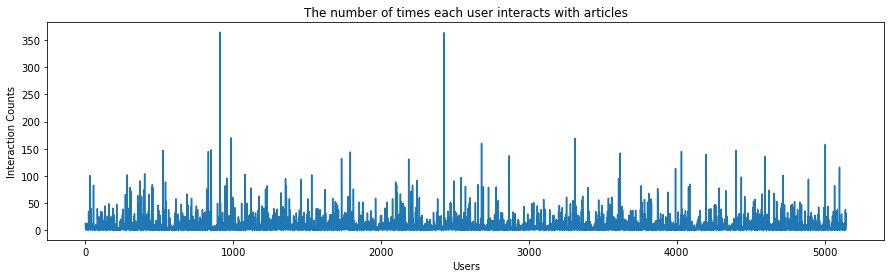

In [3]:
interation_counts = df.groupby('email')['article_id'].count().values
plt.figure(figsize=(15,4))
plt.plot(interation_counts)
plt.xlabel('Users')
plt.ylabel('Interaction Counts')
plt.title('The number of times each user interacts with articles')
plt.show();

In [4]:
print(df.groupby('email')['article_id'].count().median())
print(df.groupby('email')['article_id'].count().max())

3.0
364


In [5]:
# Fill in the median and maximum number of user_article interactios below

median_val = 3.0 # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = 364 # The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [6]:
# Find and explore duplicate articles

df_content[df_content.duplicated(['article_id'])]

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [7]:
# Remove any rows that have the same article_id - only keep the first

df_content.drop_duplicates(['article_id'], inplace=True)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [8]:
df.article_id.nunique()

714

In [9]:
df_content.article_id.nunique()

1051

In [10]:
df.email.nunique()

5148

In [11]:
df.shape[0]

45993

In [12]:
unique_articles = df.article_id.nunique() # The number of unique articles that have at least one interaction
total_articles = df_content.article_id.nunique() # The number of unique articles on the IBM platform
unique_users = df.email.nunique() # The number of unique users
user_article_interactions = df.shape[0] # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [13]:
df.article_id.value_counts().head()

1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
Name: article_id, dtype: int64

In [14]:
most_viewed_article_id = '1429.0' # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [15]:
## map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [16]:
sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test the dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, I don't actually have ratings for whether a user liked an article or not. I only know that a user has interacted with an article. In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test my function using the tests below.

In [17]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = df['title'].value_counts().index.tolist()[:n]
    top_articles = [str(i) for i in top_articles]
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = df['article_id'].value_counts().index.tolist()[:n]
    top_articles = [str(i) for i in top_articles]
 
    return top_articles # Return the top article ids

In [18]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [19]:
# Test my function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of my three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` The function below reformats the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

I use the tests to make sure the basic structure of my matrix matches what is expected by the solution.

In [20]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
   
    user_item = df.groupby(['user_id', 'article_id'])['title'].count().notnull().unstack().notnull().astype(int)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [21]:
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

I use the tests to test my function.

In [22]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    similarity = []
    
    for i in range(user_item.shape[0]):
        similarity.append((i+1, np.dot(user_item.loc[i+1].tolist(), user_item.loc[user_id].tolist())))

    # sort by similarity
    similarity = sorted(similarity, key=lambda x: x[1], reverse=True)

    # create list of just the ids
    most_similar_users = [x[0] for x in similarity]

    # remove the own user's id
    most_similar_users.remove(user_id)
    
    return most_similar_users # return a list of the users in order from most to least similar
        

In [23]:
# Do a spot check of my function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 49]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that I have a function that provides the most similar users to each user, I will use these users to find articles I can recommend. 

In [24]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = []

    for idx in article_ids:
        article_names.append(df[df['article_id']==float(idx)].max()['title'])
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    article_ids = []
    article_names = []
    ratings = user_item.loc[user_id]
    for i in range(len(ratings.values)):
        if ratings.values[i] > 0:
            article_ids.append(str(user_item.keys()[i]))
            try:
                article_names.append(df.loc[df['article_id']==float(str(user_item.keys()[i]))]['title'].values[0])
            except:
                article_names.append("Title Not Defined")
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    similar_users = find_similar_users(user_id)
    recommended_articles = []
    seen_article_ids = get_user_articles(user_id)[0]
    for user in similar_users:
        article_ids = get_user_articles(user)[0]
        recommended_articles.extend(list(set(seen_article_ids) ^ set(article_ids)))
    recs = recommended_articles[:m]
    
    return recs # return my recommendations for this user_id    

In [25]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['jupyter notebook tutorial',
 'car performance data',
 'machine learning for the enterprise',
 'awesome deep learning papers',
 'discover hidden facebook usage insights',
 'deep learning from scratch i: computational graphs',
 'this week in data science (may 2, 2017)',
 'shiny 0.13.0',
 'optimizing a marketing campaign: moving from predictions to actions',
 'automating web analytics through python']

In [26]:
# Test my functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function I wrote earlier.

In [27]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    colName = ['neighbor_id', 'similarity', 'num_interactions']
    neighbors_df = pd.DataFrame(columns = colName)
    
    for i in user_item.index.values:
        if i == user_id:
            continue
        neighbor_id = i
        similarity = user_item[user_item.index == user_id].dot(user_item.loc[i].T).values[0]
        num_interactions = user_item.loc[i].values.sum()
        neighbors_df.loc[neighbor_id] = [neighbor_id, similarity, num_interactions]
        
    neighbors_df['similarity'] = neighbors_df['similarity'].astype('int')
    neighbors_df['neighbor_id'] = neighbors_df['neighbor_id'].astype('int')
    neighbors_df = neighbors_df.sort_values(by = ['similarity', 'neighbor_id'], ascending = [False, True])
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    
    top_df = get_top_sorted_users(user_id)
    uid_list = top_df['neighbor_id'].values.tolist()
    recs = []
    name_ids = []

    exp_article_ids = list(set(df[df['user_id'] == user_id]['article_id'].values.tolist()))

    for uid in uid_list:
        recs += df[df['user_id'] == uid]['article_id'].values.tolist()

    recs = list(set(recs))
    recs = [ x for x in recs if x not in exp_article_ids ]

    rec_all = df[df.article_id.isin(recs)][['article_id','title']].drop_duplicates().head(m)
    recs = rec_all['article_id'].values.tolist()
    rec_names = rec_all['title'].values.tolist()
    
    return recs, rec_names

In [28]:
# Quick spot check - don't change this code - just use it to test my functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1430.0, 1314.0, 1429.0, 1338.0, 1276.0, 1432.0, 593.0, 1185.0, 993.0, 14.0]

The top 10 recommendations for user 20 are the following article names:
['using pixiedust for fast, flexible, and easier data analysis and experimentation', 'healthcare python streaming application demo', 'use deep learning for image classification', 'ml optimization using cognitive assistant', 'deploy your python model as a restful api', 'visualize data with the matplotlib library', 'upload files to ibm data science experience using the command line', 'classify tumors with machine learning', 'configuring the apache spark sql context', 'got zip code data? prep it for analytics. – ibm watson data lab – medium']


`5.` Use my functions from above to correctly fill in the solutions to the dictionary below.  Then test my dictionary against the solution.  

In [29]:
get_top_sorted_users(1).head(5)

,neighbor_id,similarity,num_interactions
3933,3933,35,35
23,23,17,135
3782,3782,17,135
203,203,15,96
4459,4459,15,96


In [30]:
get_top_sorted_users(131).head(10)

,neighbor_id,similarity,num_interactions
3870,3870,74,75
3782,3782,39,135
23,23,38,135
203,203,33,96
4459,4459,33,96
49,49,29,101
98,98,29,97
3697,3697,29,100
3764,3764,29,97
242,242,25,59


In [31]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1).iloc[0].neighbor_id # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).iloc[9].neighbor_id # Find the 10th most similar user to user 131

In [32]:
## Dictionary Test Here

sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


If we were given a new user, all these methods would not work because we do not have data about the new users and thus can not compare the new user's similarity to our existing users. We could consider using Rank Based Recommendations and the get_top_articles function to make recommendations. After we accumulate certain information about the user, we could use the 3 types of recommendation techniques; Rank, Content, and Collaborative.

`7.` Using my existing functions, provide the top 10 recommended articles I would provide for the a new user below.  

In [33]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10, df) # my recommendations here

In [34]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Matrix-Fact">Part IV: Matrix Factorization</a>

In this part of the notebook, I will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` I have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that I run the cells to get things set up for the rest of **Part V** of the notebook. 

In [35]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [36]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, I use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [37]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices

**We have no missing values in this matrix therefore we can perform SVD.  The matrix has missing values in the lessons.**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, while the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix. I run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

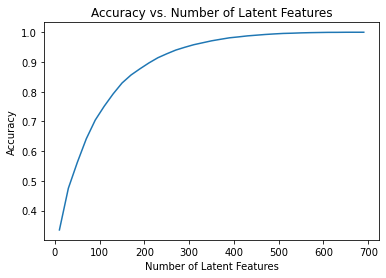

In [38]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

I use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [39]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    train_idx = set(user_item_train.index)
    test_idx = set(user_item_test.index)
    match_idx = list(train_idx.intersection(test_idx))
    
    train_arts = set(user_item_train.columns)
    test_arts =  set(user_item_test.columns)
    match_cols = list(train_arts.intersection(test_arts))

    user_item_test = user_item_test.loc[match_idx, match_cols]

    return user_item_train, user_item_test, test_idx, test_arts


user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [40]:
print(len(test_idx) - user_item_test.shape[0])
print(len(test_arts))
print(user_item_test.shape[0])
print(len(test_arts) - user_item_test.shape[1])

662
574
20
0


In [41]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that I can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

I use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [42]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below

In [43]:
test_idx_common = user_item_train.index.isin(test_idx)
test_arts_common = user_item_train.columns.isin(test_arts)
u_test = u_train[test_idx_common, :]
vt_test = vt_train[:, test_arts_common]

In [44]:
# Use these cells to see how well I can use the training 
# decomposition to predict on test data

num_latent_feats = np.arange(10,700+10,20)
train_sum_errs = []
test_sum_errs = []

user_intersection_train_test = df_test[df_test['user_id'].isin(df_train['user_id'])].dropna()['user_id'].unique()
user_intersection_train_test_matrix = user_item_test[user_item_test.index.isin(user_intersection_train_test)]

for k in num_latent_feats:
    # restructure with k latent features
    s_train_new, u_train_new, vt_train_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_new, vt_test_new = u_test[:, :k], vt_test[:k, :]
    
    # take dot product
    user_item_train_est = np.around(np.dot(np.dot(u_train_new, s_train_new), vt_train_new))
    user_item_test_est = np.around(np.dot(np.dot(u_test_new, s_train_new), vt_test_new))
    
    # compute error for each prediction to actual value
    train_diffs = np.subtract(user_item_train, user_item_train_est)
    test_diffs = np.subtract(user_intersection_train_test_matrix, user_item_test_est)
    
    # total errors and keep track of them 
    train_err = np.sum(np.sum(np.abs(train_diffs)))
    test_err = np.sum(np.sum(np.abs(test_diffs)))
    train_sum_errs.append(train_err)
    test_sum_errs.append(test_err)

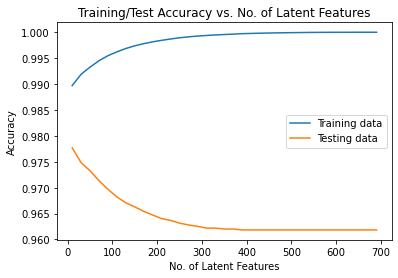

In [45]:
# plot the training data

plt.plot(num_latent_feats, 1 - np.array(train_sum_errs)/(user_item_train.shape[0] 
                                                         * user_intersection_train_test_matrix.shape[1]), label='Training data')
plt.plot(num_latent_feats, 1 - np.array(test_sum_errs)/(user_intersection_train_test_matrix.shape[0] 
                                                        * user_intersection_train_test_matrix.shape[1]), label='Testing data')
plt.xlabel('No. of Latent Features')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training/Test Accuracy vs. No. of Latent Features')
plt.show()

- As we can see from the plot, the training accuracy increases with increased features, whereas the testing accuracy decreases with an increased number of features. It suggests overfitting of the training data. It also indicates that we should use a smaller amount of data.


- Since I only have 20 users, it makes any change in the training/testing size would affect the results. Thus, other methods such as rank-based or content-based recommendations would be more suitable. To test and validate recommendation effectiveness, we would use A/B testing for new users to solve the cold start problem. Once we accumulate more data, this method could ten be used.

## Conclusion

- In this analysis, I build out several different methods for making recommendations that can be used for different situations. I first explore the data I'm working with and then first do rank-based recommendations. To improve upon this I then use user-based collaborative filtering. Finally, I complete a machine learning approach to building recommendations by using the user-item interactions I build out a matrix decomposition.


- When using SVD I experience the cold start problem. That is, I can only make predictions for articles and users that exist in both the training and test sets. For users in the test dataset that are not in the training set, I cannot predict articles to recommend to that user. In this case, other methods, such as knowledge-based,  content-based, or A/B testing would probably be more suitable methods.

In [46]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

1